In [1]:
import glob

import cartopy.crs as ccrs
import cftime
import cmocean as cmo
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import momlevel as ml
import numpy as np
import om4labs.om4common as om4
import pandas as pd
import scipy.signal as signal
import xarray as xr
from scipy.stats import linregress

# parameters for setting circular cutoff for Southern Ocean plots
theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

out_path_fig = "/work/Katherine.Turner/smaller_projects/hifreq-variability/figures/"
out_path_data = "/work/Katherine.Turner/smaller_projects/hifreq-variability/data/"


def regress(y, x):
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    return slope  # or return r_value, p_value, etc.


def get_SAM_residuals(SAM_index, da):
    # Apply regression across lat/lon grid
    slope_map = xr.apply_ufunc(
        regress,
        da,
        SAM_index,
        input_core_dims=[["time"], ["time"]],
        vectorize=True,
        dask="parallelized",  # optional: speeds things up with dask
        output_dtypes=[float],
    )

    resid = da - da.mean(dim="time") - SAM_index * slope_map
    return resid, slope_map

In [19]:
mod = "CM4"

# getting SAM indices
SAM = {}
season = ["DJF", "JJA"]
for s in season:
    ds = xr.open_dataset(
        f"/work/Katherine.Turner/smaller_projects/hifreq-variability/data/{mod}_cmip_{s}_SAM.nc"
    )

    if mod == "ESM4":
        if s == "DJF":
            SAM[s] = ds.pcs[1:-1, 0]
        else:
            SAM[s] = ds.pcs[:, 0]

    if mod == "CM4":
        if s == "DJF":
            SAM[s] = ds.pcs[151:-1, 0]
        else:
            SAM[s] = ds.pcs[150:, 0]


ds = xr.open_dataset(
    f"/work/Katherine.Turner/smaller_projects/hifreq-variability/data/{mod}_cmip_monthly_storms.nc",
    use_cftime=True,
)

storms_seasonal = ds.center_counts.resample(time="QS-DEC").sum()

idx_jja = storms_seasonal.time.dt.month == 6
idx_djf = storms_seasonal.time.dt.month == 12

storms_djf = (
    storms_seasonal[idx_djf][1:-1] - storms_seasonal[idx_djf][1:-1].mean()
) / storms_seasonal[idx_djf][1:-1].std()
storms_jja = (
    storms_seasonal[idx_jja] - storms_seasonal[idx_jja].mean()
) / storms_seasonal[idx_jja].std()

STV = {}
STV["DJF"] = storms_djf
STV["JJA"] = storms_jja

low_storms = {}
high_storms = {}

low_storms["DJF"] = storms_djf.sortby(storms_djf).time[:50]
high_storms["DJF"] = storms_djf.sortby(storms_djf).time[-50:]

low_storms["JJA"] = storms_jja.sortby(storms_jja).time[:50]
high_storms["JJA"] = storms_jja.sortby(storms_jja).time[-50:]

# Loading in variable of choice and creating SAM residuals for compositing

In [29]:
vd = {
    "tos": {
        "realm": "ocean_monthly_1x1deg",
        "v_DJF": 0.6,
        "v_JJA": 0.6,
        "units": "$^{\circ}$C",
        "title": "SST",
    },
    "zossq": {
        "realm": "ocean_monthly_1x1deg",
        "v_DJF": 0.06,
        "v_JJA": 0.08,
        "units": "m$^2$",
        "title": "$\eta^2$",
    },
    "omldamax": {
        "realm": "ocean_monthly_1x1deg",
        "v_DJF": 10,
        "v_JJA": 20,
        "units": "m",
        "title": "MLD",
    },
    "hfds": {
        "realm": "ocean_monthly_1x1deg",
        "v_DJF": 10,
        "v_JJA": 20,
        "units": "W m$^{-2}$",
        "title": "$F_{heat}$",
    },
    "sos": {
        "realm": "ocean_monthly_1x1deg",
        "v_DJF": 0.1,
        "v_JJA": 0.05,
        "units": "psu",
        "title": "SSS",
    },
}

v = {
    "DJF": {
        "dic_stf_gas": 1e-8,
    },
    "JJA": {
        "dic_stf_gas": 2e-8,
    },
}
lab_var = {"dic_stf_gas": "mol m$^{-2}$ s$^{-1}$"}

In [21]:
var = "sos"
realm = vd[var]["realm"]


if var == "hf_turb":
    ds_v = xr.open_mfdataset(
        f"/work/Katherine.Turner/tempest-extremes/{mod}_cmip/data/ocean_monthly_1x1deg*hf*.nc",
        use_cftime=True,
    )
    ds_v = ds_v.assign(hf_turb=ds_v["hflso"] + ds_v["hfsso"])

else:
    ds_v = xr.open_mfdataset(
        f"/work/Katherine.Turner/tempest-extremes/{mod}_cmip/data/{realm}*{var}.nc",
        use_cftime=True,
    )

da_v = ds_v[var]

da_v_s = da_v.resample(time="QS-DEC").sum()

da = {}

da["DJF"] = (da_v_s[4:-4:4, :, :] / 3).compute()
da["JJA"] = (da_v_s[2::4, :, :] / 3).compute()

da_resid = {}
slope = {}

idx_high = {}
idx_low = {}

for s in season:
    da_resid[s], slope[s] = get_SAM_residuals(SAM[s], da[s])

    idx_high[s] = da_resid[s].time.dt.year.isin(high_storms[s].dt.year)
    idx_low[s] = da_resid[s].time.dt.year.isin(low_storms[s].dt.year)

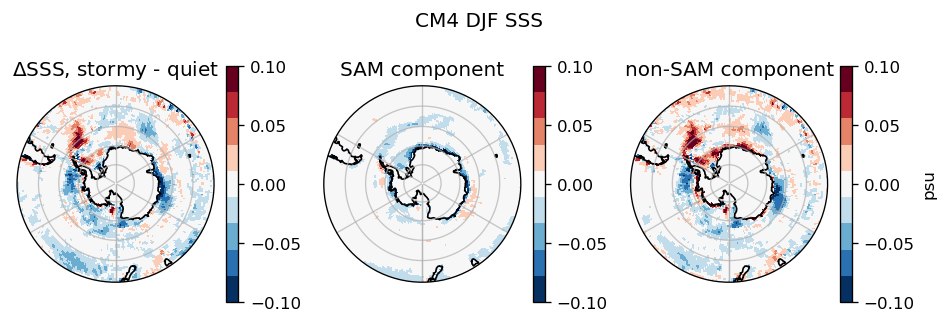

In [26]:
s = "DJF"

SAM_highstorms = SAM[s][SAM[s].time.dt.year.isin(high_storms[s].dt.year)].mean()
SAM_lowstorms = SAM[s][SAM[s].time.dt.year.isin(low_storms[s].dt.year)].mean()
dSAM = SAM_highstorms - SAM_lowstorms

fig, axs = plt.subplots(
    nrows=1,
    ncols=3,
    figsize=(8, 2.7),
    dpi=120,
    subplot_kw={"projection": ccrs.SouthPolarStereo()},
)
axs = axs.flatten()

(
    da[s][idx_high[s], :, :].mean(dim="time") - da[s][idx_low[s], :, :].mean(dim="time")
).plot(
    ax=axs[0],
    vmin=-1 * vd[var]["v_DJF"],
    vmax=vd[var]["v_DJF"],
    extend="neither",
    cmap=plt.get_cmap("RdBu_r", 9),
    x="lon",
    y="lat",
    transform=ccrs.PlateCarree(),
    cbar_kwargs={"label": ""},
)
axs[0].set_title(f"$\Delta${vd[var]['title']}, stormy - quiet")

(dSAM * slope[s]).plot(
    ax=axs[1],
    vmin=-1 * vd[var]["v_DJF"],
    vmax=vd[var]["v_DJF"],
    extend="neither",
    cmap=plt.get_cmap("RdBu_r", 9),
    x="lon",
    y="lat",
    transform=ccrs.PlateCarree(),
    cbar_kwargs={"label": ""},
)
axs[1].set_title(f"SAM component")

(
    da_resid[s][idx_high[s], :, :].mean(dim="time")
    - da_resid[s][idx_low[s], :, :].mean(dim="time")
).plot(
    ax=axs[2],
    vmin=-1 * vd[var]["v_DJF"],
    vmax=vd[var]["v_DJF"],
    extend="neither",
    cmap=plt.get_cmap("RdBu_r", 9),
    x="lon",
    y="lat",
    transform=ccrs.PlateCarree(),
    cbar_kwargs={"label": vd[var]["units"]},
)
axs[2].set_title(f"non-SAM component")

for i in range(3):
    axs[i].set_ylabel("")
    axs[i].set_xlabel("")
    axs[i].set_extent([-180, 180, -90, -40], ccrs.PlateCarree())
    axs[i].gridlines(alpha=0.7)
    axs[i].set_boundary(circle, transform=axs[i].transAxes)
    axs[i].coastlines()

fig.suptitle(f"{mod} {s} {vd[var]['title']}")

plt.tight_layout()

plt.savefig(f"{out_path_fig}composites/{var}_{s}_{mod}.png", format="png", dpi=100)

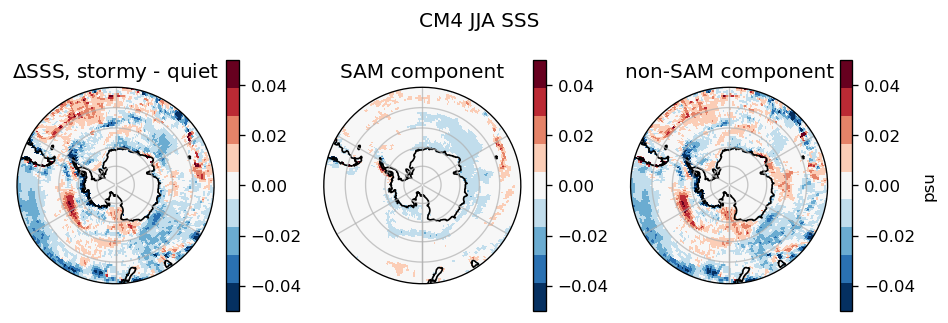

In [30]:
s = "JJA"

SAM_highstorms = SAM[s][SAM[s].time.dt.year.isin(high_storms[s].dt.year)].mean()
SAM_lowstorms = SAM[s][SAM[s].time.dt.year.isin(low_storms[s].dt.year)].mean()
dSAM = SAM_highstorms - SAM_lowstorms

fig, axs = plt.subplots(
    nrows=1,
    ncols=3,
    figsize=(8, 2.7),
    dpi=120,
    subplot_kw={"projection": ccrs.SouthPolarStereo()},
)
axs = axs.flatten()

(
    da[s][idx_high[s], :, :].mean(dim="time") - da[s][idx_low[s], :, :].mean(dim="time")
).plot(
    ax=axs[0],
    vmin=-1 * vd[var]["v_JJA"],
    vmax=vd[var]["v_JJA"],
    extend="neither",
    cmap=plt.get_cmap("RdBu_r", 9),
    x="lon",
    y="lat",
    transform=ccrs.PlateCarree(),
    cbar_kwargs={"label": ""},
)
axs[0].set_title(f"$\Delta${vd[var]['title']}, stormy - quiet")

(dSAM * slope[s]).plot(
    ax=axs[1],
    vmin=-1 * vd[var]["v_JJA"],
    vmax=vd[var]["v_JJA"],
    extend="neither",
    cmap=plt.get_cmap("RdBu_r", 9),
    x="lon",
    y="lat",
    transform=ccrs.PlateCarree(),
    cbar_kwargs={"label": ""},
)
axs[1].set_title(f"SAM component")

(
    da_resid[s][idx_high[s], :, :].mean(dim="time")
    - da_resid[s][idx_low[s], :, :].mean(dim="time")
).plot(
    ax=axs[2],
    vmin=-1 * vd[var]["v_JJA"],
    vmax=vd[var]["v_JJA"],
    extend="neither",
    cmap=plt.get_cmap("RdBu_r", 9),
    x="lon",
    y="lat",
    transform=ccrs.PlateCarree(),
    cbar_kwargs={"label": vd[var]["units"]},
)
axs[2].set_title(f"non-SAM component")

for i in range(3):
    axs[i].set_ylabel("")
    axs[i].set_xlabel("")
    axs[i].set_extent([-180, 180, -90, -40], ccrs.PlateCarree())
    axs[i].gridlines(alpha=0.7)
    axs[i].set_boundary(circle, transform=axs[i].transAxes)
    axs[i].coastlines()
    
fig.suptitle(f"{mod} {s} {vd[var]['title']}")

plt.tight_layout()

plt.savefig(f"{out_path_fig}composites/{var}_{s}_{mod}.png", format="png", dpi=100)

## Interior composite fields

In [16]:
var = "rho_0"

ds_v = xr.open_mfdataset(
    f"/work/Katherine.Turner/tempest-extremes/{mod}_cmip/data/*{var}.nc",
    use_cftime=True,
)

da_v = ds_v[var]

da_v_s = da_v.resample(time="QS-DEC").sum()

da = {}

da["DJF"] = (da_v_s[4:-4:4, :, :, :] / 3).compute()
da["JJA"] = (da_v_s[2::4, :, :, :] / 3).compute()

da_resid = {}
slope = {}

idx_high = {}
idx_low = {}

for s in season:
    da_resid[s], slope[s] = get_SAM_residuals(SAM[s], da[s])

    idx_high[s] = da_resid[s].time.dt.year.isin(high_storms[s].dt.year)
    idx_low[s] = da_resid[s].time.dt.year.isin(low_storms[s].dt.year)

da["DJF"] = da["DJF"].where(da["DJF"] != 0, np.nan)
da["JJA"] = da["JJA"].where(da["JJA"] != 0, np.nan)

slope["DJF"] = slope["DJF"].where(slope["DJF"] != 0, np.nan)
slope["JJA"] = slope["JJA"].where(slope["JJA"] != 0, np.nan)

da_resid["DJF"] = da_resid["DJF"].where(da_resid["DJF"] != 0, np.nan)
da_resid["JJA"] = da_resid["JJA"].where(da_resid["JJA"] != 0, np.nan)

In [10]:
regions = {
    "e_pac": slice(360 - 180, 360 - 100),
    "e_ind": slice(120, 170),
    "w_ind": slice(60, 120),
}

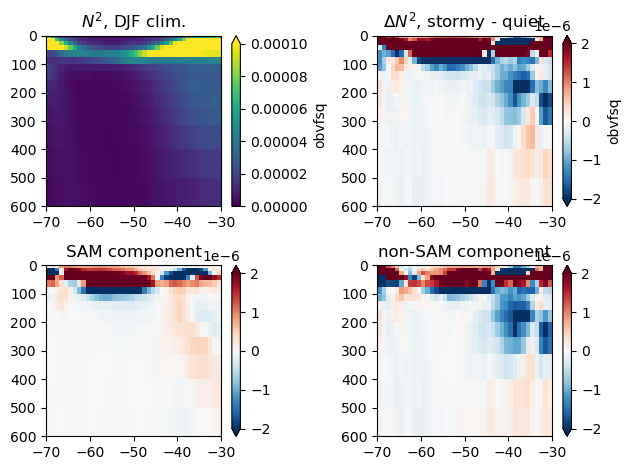

In [91]:
s = "DJF"

fig, axs = plt.subplots(nrows=2, ncols=2)

axs = axs.flatten()

da[s].mean(dim="time").sel(lon=regions["e_pac"]).mean(dim="lon").plot(
    ax=axs[0], y="z_i", vmax=1e-4
)

(
    da[s][idx_high[s], :, :, :].mean(dim="time")
    - da[s][idx_low[s], :, :, :].mean(dim="time")
).sel(lon=regions["e_pac"]).mean(dim="lon").plot(
    ax=axs[1], y="z_i", vmin=-2e-6, vmax=2e-6, cmap="RdBu_r"
)

(dSAM * slope[s]).sel(lon=regions["e_pac"]).mean(dim="lon").plot(
    ax=axs[2], y="z_i", vmin=-2e-6, vmax=2e-6, cmap="RdBu_r"
)

(
    da_resid[s][idx_high[s], :, :].mean(dim="time")
    - da_resid[s][idx_low[s], :, :].mean(dim="time")
).sel(lon=regions["e_pac"]).mean(dim="lon").plot(
    ax=axs[3],
    y="z_i",
    vmin=-2e-6,
    vmax=2e-6,
    cmap="RdBu_r",
)

axs[0].set_title(f"$N^2$, {s} clim.")
axs[1].set_title("$\Delta N^2$, stormy - quiet")
axs[2].set_title(f"SAM component")
axs[3].set_title(f"non-SAM component")

for i in range(4):
    axs[i].set_xlabel("")
    axs[i].set_ylabel("")
    axs[i].set_ylim([600, 0])
    axs[i].set_xlim([-70, -30])

plt.tight_layout()

Text(0.5, 0.98, 'ESM4 JJA $p_0$')

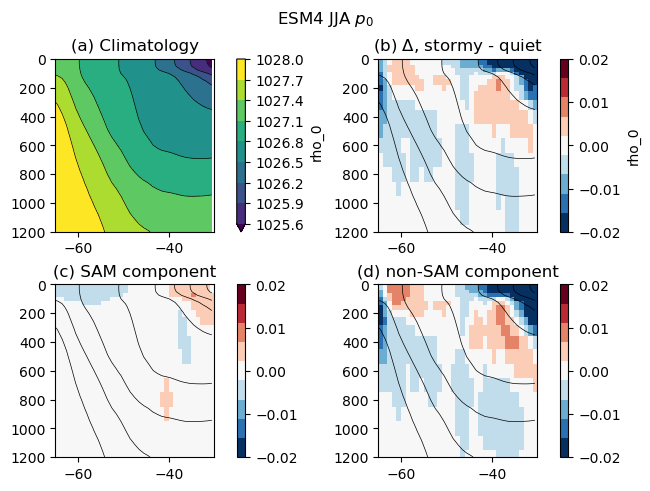

In [17]:
s = "JJA"
r = "e_pac"

SAM_highstorms = SAM[s][SAM[s].time.dt.year.isin(high_storms[s].dt.year)].mean()
SAM_lowstorms = SAM[s][SAM[s].time.dt.year.isin(low_storms[s].dt.year)].mean()
dSAM = SAM_highstorms - SAM_lowstorms

if var == "pv":
    levels, colors = ml.util.get_pv_colormap()
    v0 = 15
if var == "obvfsq":
    v0 = 2e-6
if var == "dissic":
    v0 = 4e-3
if var == "rho_0":
    v0 = 2e-2

fig, axs = plt.subplots(nrows=2, ncols=2, constrained_layout=True)

axs = axs.flatten()

da[s].mean(dim="time").sel(lon=regions[r]).mean(dim="lon").plot.contourf(
    ax=axs[0],
    # levels=levels, colors=colors,#
    # vmax=3e-5, vmin=0, levels=9, cmap='plasma',
    # vmax=2.3, vmin=2, levels=9, cmap='jet',
    vmax=1028,
    vmin=1025.6,
    levels=9,
    cmap="viridis",
)

(
    da[s][idx_high[s], :, :, :].mean(dim="time")
    - da[s][idx_low[s], :, :, :].mean(dim="time")
).sel(lon=regions[r]).mean(dim="lon").plot(
    ax=axs[1], vmin=-1 * v0, vmax=v0, extend="neither", cmap=plt.get_cmap("RdBu_r", 9)
)

(dSAM * slope[s]).sel(lon=regions[r]).mean(dim="lon").plot(
    ax=axs[2], vmin=-1 * v0, vmax=v0, extend="neither", cmap=plt.get_cmap("RdBu_r", 9)
)

(
    da_resid[s][idx_high[s], :, :].mean(dim="time")
    - da_resid[s][idx_low[s], :, :].mean(dim="time")
).sel(lon=regions[r]).mean(dim="lon").plot(
    ax=axs[3],
    vmin=-1 * v0,
    vmax=v0,
    extend="neither",
    cmap=plt.get_cmap("RdBu_r", 9),
)

for i in range(4):
    da[s].mean(dim="time").sel(lon=regions[r]).mean(dim="lon").plot.contour(
        ax=axs[i],
        # vmax=4e-5, vmin=0,
        # vmax=2.3, vmin=2,
        vmax=1028,
        vmin=1025.6,
        levels=9,
        colors="k",
        linewidths=0.5,
    )
    axs[i].set_xlabel("")
    axs[i].set_ylabel("")
    axs[i].set_ylim([1200, 0])
    axs[i].set_xlim([-65, -30])


axs[0].set_title(f"(a) Climatology")
axs[1].set_title("(b) $\Delta$, stormy - quiet")
axs[2].set_title(f"(c) SAM component")
axs[3].set_title(f"(d) non-SAM component")

fig.suptitle(f"{mod} {s} $p_0$")
# plt.tight_layout()

# Creating multiple linear regression with SAM and STV

In [9]:
season

['DJF', 'JJA']

In [73]:
import statsmodels.api as sm

X = {}

for s in season:
    X[s] = xr.Dataset({"SAM": SAM[s]})  # , 'STV': STV[s]})
    X[s] = sm.add_constant(X[s].to_array().transpose("time", ...))

In [77]:
realm = "ocean_monthly"
var = "omldamax"

if var == "hf_turb":
    ds_v = xr.open_mfdataset(
        f"/work/Katherine.Turner/tempest-extremes/ESM4_cmip/data/ocean_monthly_1x1deg*hf*.nc",
        use_cftime=True,
    )
    ds_v = ds_v.assign(hf_turb=ds_v["hflso"] + ds_v["hfsso"])

else:
    ds_v = xr.open_mfdataset(
        f"/work/Katherine.Turner/tempest-extremes/ESM4_cmip/data/{realm}*{var}.nc",
        use_cftime=True,
    )

da_v = ds_v[var]

da_v_s = da_v.resample(time="QS-DEC").sum()

da = {}

da["DJF"] = (da_v_s[4:-4:4, :, :] / 3).compute()
da["JJA"] = (da_v_s[2::4, :, :] / 3).compute()

In [78]:
r2 = {}
r2["DJF"] = np.zeros(shape=(60, 360))
r2["JJA"] = np.zeros(shape=(60, 360))

for s in season:
    for i in range(60):
        for j in range(360):
            if da[s][0, i, j] != 0:
                model = sm.OLS(da[s][:, i, j].values, X[s])
                r2[s][i, j] = model.fit().rsquared
            else:
                r2[s][i, j] = np.nan

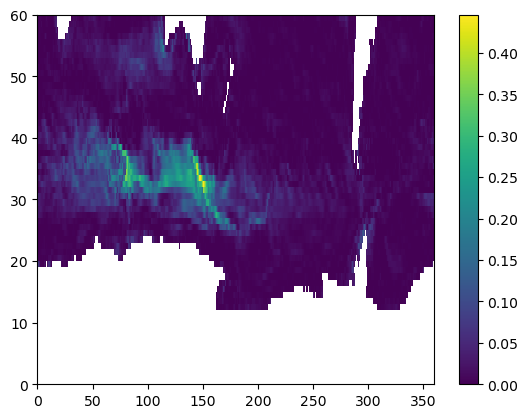

In [80]:
plt.pcolormesh(r2["JJA"])
plt.colorbar()